In [40]:
# numpy: For numerical operations and array manipulations
# pandas: For data manipulation and analysis (DataFrames, CSV reading)
# warnings: To suppress warning messages for cleaner output
# datetime: To track how long the code takes to run
import numpy as np
import pandas as pd
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

DATA_PATH = '/kaggle/input/china-real-estate-demand-prediction'
SEED = 42
np.random.seed(SEED)# Set random seed for reproducibility (ensures same results every run)

start = datetime.now()


In [41]:
# ─────────────────────────────────────────────────────────────────────────────
# Dataset Overview
# ─────────────────────────────────────────────────────────────────────────────
print(f"\nDataset: {train_nht.shape[0]:,} rows × {train_nht.shape[1]} cols | "
      f"Date Range: {train_nht['month'].min()} → {train_nht['month'].max()}")
print(f"Sectors: {train_nht['sector'].nunique()} | "
      f"Months: {train_nht['month'].nunique()} | "
      f"Predictions: {len(test):,}")

amounts = train_nht['amount_new_house_transactions']
print(f"\nTransactions - Mean: {amounts.mean():,.0f} | Median: {amounts.median():,.0f} | "
      f"Std: {amounts.std():,.0f} | Zeros: {(amounts==0).sum():,} ({100*(amounts==0).mean():.1f}%)")



Dataset: 5,433 rows × 11 cols | Date Range: 2019-Apr → 2024-May
Sectors: 95 | Months: 67 | Predictions: 1,152

Transactions - Mean: 32,588 | Median: 16,040 | Std: 49,048 | Zeros: 0 (0.0%)


In [42]:
 """
    Extracts useful information from the data:
    - sector_id: Extracts the sector number (e.g., "sector_5" -> 5)
    - year: Extracts the year from month string (e.g., "2019-Jan" -> 2019)
    - month_num: Converts month text to number (e.g., "Jan" -> 1)
    - time: Creates a single time index starting from 2019 (month 0 = Jan 2019)
    """
def build_month_codes():
    return {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
            'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}  #  Create mapping: month abbreviation to number

def add_time_and_sector_fields(df, month_codes):
    
    if 'sector' in df.columns:
        df['sector_id'] = df['sector'].str.slice(7, None).astype(int)
    
    if 'month' in df.columns:
        df['year'] = df['month'].str.slice(0, 4).astype(int)
        df['month_num'] = df['month'].str.slice(5, None).map(month_codes)
    else:
        df['month_num'] = df['month_text'].str.slice(5, None).map(month_codes)
        df['year'] = df['month_text'].str.slice(0, 4).astype(int)# Create time index: (year - 2019) * 12 + month - 1
    # Example: Jan 2019 = 0, Dec 2019 = 11, Jan 2020 = 12
    
    df['time'] = (df['year'] - 2019) * 12 + df['month_num'] - 1  
    return df

def build_amount_matrix(train_nht, month_codes):
    train_nht = add_time_and_sector_fields(train_nht.copy(), month_codes)
    pivot = train_nht.set_index(['time', 'sector_id']).amount_new_house_transactions.unstack()
    pivot = pivot.fillna(0)
    
    all_sectors = np.arange(1, 97)
    for s in all_sectors:
        if s not in pivot.columns:
            pivot[s] = 0
    
    return pivot[all_sectors]

def split_test_id_column(df):
    parts = df['id'].str.split('_', expand=True)
    df['month_text'] = parts[0]
    df['sector'] = parts[1]
    return df  # Return DataFrame with parsed month_text and sector


In [43]:
  """
    Calculates Exponentially Weighted Geometric Mean (EWGM) for a sector.
    
    EWGM gives more weight to recent months and less to older months.
    This helps capture recent trends in real estate transactions.
    
    Parameters:
    - a_tr: Historical transaction data matrix
    - sector: Which sector to calculate for (1-96)
    - n_lags: How many past months to use (e.g., 12 months)
    - alpha: Decay factor (0-1). Lower = more weight on recent months
    """
def ewgm_per_sector(a_tr, sector, n_lags, alpha):
   
    weights = np.array([alpha**(n_lags - 1 - i) for i in range(n_lags)], dtype=float)
    weights = weights / weights.sum()
    recent_vals = a_tr.tail(n_lags)[sector].values
    
    if (len(recent_vals) != n_lags) or (recent_vals <= 0).all():
        return 0.0
    
    mask = recent_vals > 0
    pos_vals = recent_vals[mask]
    pos_w = weights[mask]
    
    if pos_vals.size == 0:
        return 0.0
    
    pos_w = pos_w / pos_w.sum()
    log_vals = np.log(pos_vals + 1e-12)
    wlm = np.sum(pos_w * log_vals)
    
    return float(np.exp(wlm))  # convert back from log space

def predict_horizon(a_tr, alpha, n_lags, t2, allow_zeros):
    idx = np.arange(67, 79)
    cols = a_tr.columns
    a_pred = pd.DataFrame(index=idx, columns=cols, dtype=float)
    
    for sector in cols:
        if (a_tr.tail(t2)[sector] == 0).mean() > allow_zeros / t2 + 1e-8 or (a_tr[sector].sum() == 0):  #  this is to Skip dead sectors
            a_pred[sector] = 0.0
            continue
        
        base_last_value = a_tr[sector].iloc[-1]
        base_ewgm = ewgm_per_sector(a_tr=a_tr, sector=sector, n_lags=n_lags, alpha=alpha)
        
        a_pred[sector] = 0.34 * base_last_value + 0.34 * base_ewgm  # Formula: 0.34 * Last_Value + 0.34 * EWGM   this to prdict the horizon in this code 
    
    a_pred.index.rename('time', inplace=True)
    return a_pred

def compute_december_multipliers(a_tr, eps=1e-9, clip_low=0.85, clip_high=1.4): # Clip multiplier to reasonable range [0.85, 1.40] 
    is_december = (a_tr.index.values % 12) == 11
    
    #Calculates how much December differs from other months for each sector.
    
    #Real estate often has seasonal patterns - December might be higher or lower
    #than average. This function finds that pattern and creates multipliers.
    
    #Returns a dictionary: {sector_id: multiplier}
    #Example: {5: 1.2} means sector 5 has 20% more transactions in December
    
    dec_means = a_tr[is_december].mean(axis=0)
    nondec_means = a_tr[~is_december].mean(axis=0)
    
    raw_mult = dec_means / (nondec_means + eps)
    raw_mult = raw_mult.replace([np.inf, -np.inf], 1.0).fillna(1.0)
    clipped_mult = raw_mult.clip(lower=clip_low, upper=clip_high)
    
    return clipped_mult.to_dict()

def apply_december_bump(a_pred, sector_to_mult):
    
    dec_rows = [t for t in a_pred.index.values if (t % 12) == 11]  # (time % 12) == 11 (month 11 = December) this the formula i used on thsi line
    if len(dec_rows) == 0:
        return a_pred
    
    for sector in a_pred.columns:
        m = sector_to_mult.get(sector, 1.0)
        a_pred.loc[dec_rows, sector] = a_pred.loc[dec_rows, sector] * m
    
    return a_pred

def build_submission_df(a_pred, test_raw, month_codes):
     
    #Converts predictions into the submission format required by the competition.
    
    #Takes the prediction matrix and matches it with test IDs to create
   # the final submission file with columns: id, new_house_transaction_amount
    
    test = split_test_id_column(test_raw.copy())
    test = add_time_and_sector_fields(test, month_codes)
    lookup = a_pred.stack().rename('pred').reset_index().rename(columns={'level_1': 'sector_id'})
    merged = test.merge(lookup, how='left', on=['time', 'sector_id'])
    merged['pred'] = merged['pred'].fillna(0.0)
    out = merged[['id', 'pred']].rename(columns={'pred': 'new_house_transaction_amount'})
    return out


In [44]:
# data loading form the dataset given
# Read the training data, test data, and sample submission file
# These CSV files contain the historical transactions and test cases


train_nht = pd.read_csv(f'{DATA_PATH}/train/new_house_transactions.csv')
test = pd.read_csv(f'{DATA_PATH}/test.csv')
sample_submission = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')


In [45]:
# this creates the matrix of Amount Time-Sector Matrix that will help us to Store historical data to calculate EWGM and Last Value
# Convert the training data into a matrix format:
# - Rows = time periods (months from 2019 onwards)
# - Columns = sectors (1 to 96)
# - Values = transaction amounts
#
# This matrix makes it easy to:
# 1. Look up historical values for any sector at any time
# 2. Calculate EWGM (trends) for each sector
# 3. Find the last known value for each sector
month_codes = build_month_codes()
a_tr = build_amount_matrix(train_nht, month_codes)


In [46]:

# Predict future transaction amounts using:
# - Last known value (most recent month)
# - EWGM (trend from recent 12 months)
#
# Parameters explained:
# - alpha=0.5: Controls how much weight recent months get vs older months
#              Lower alpha = more emphasis on very recent months
# - n_lags=12: Use last 12 months of history to calculate trends
# - t2=10: Check last 10 months to identify inactive sectors
# - allow_zeros=2: Allow up to 2 zero months in recent history
a_pred = predict_horizon(a_tr=a_tr, alpha=0.5, n_lags=12, t2=10, allow_zeros=2)
 #  to Use 12 months of history and i am setting the alpha as 0.5 to Controls EWGM weight distribution



In [47]:
# Real estate transactions often have seasonal patterns.
# December might be different from other months (holiday season, year-end rush, etc.)
#
# This step:
# 1. Calculates how much December differs from average for each sector
# 2. Applies that adjustment to December predictions
#
# Example: If sector 5 typically has 20% more transactions in December,
#          we multiply December predictions by 1.2

sector_to_mult = compute_december_multipliers(a_tr, clip_low=0.85, clip_high=1.4)
a_pred = apply_december_bump(a_pred, sector_to_mult)




In [48]:
# submission
# Convert predictions into the format required for submission:
# - Match predictions with test IDs
# - Create CSV file with columns: id, new_house_transaction_amount
# - This file can be uploaded to the competition platform
submission = build_submission_df(a_pred, test, month_codes)
submission.to_csv('submission.csv', index=False)


In [49]:


final_pred = submission['new_house_transaction_amount'].values

# Print summary statistics to understand our predictions:
# - Mean/Median: Average prediction values
# - Std Dev: How spread out the predictions are
# - Min/Max: Range of predictions
# - Zeros: How many sectors have no predicted transactions
#
# This helps verify that predictions look reasonable before submission
print(f"Mean:        {final_pred.mean():>15,.2f}")
print(f"Median:      {np.median(final_pred):>15,.2f}")
print(f"Std Dev:     {np.std(final_pred):>15,.2f}")
print(f"Min:         {final_pred.min():>15,.2f}")
print(f"Max:         {final_pred.max():>15,.2f}")
print(f"Zeros:       {(final_pred == 0).sum():>6} / {len(final_pred)} ({100*(final_pred==0).mean():.1f}%)")



Mean:              17,083.86
Median:             7,494.00
Std Dev:           23,557.07
Min:                    0.00
Max:              127,709.46
Zeros:          216 / 1152 (18.8%)


DATA ANALYSIS & VISUALIZATION

 Amount Matrix: 67 months × 96 sectors | Sparsity: 15.5% zeros
Top 5 Active Sectors: S55, S85, S86, S66, S4


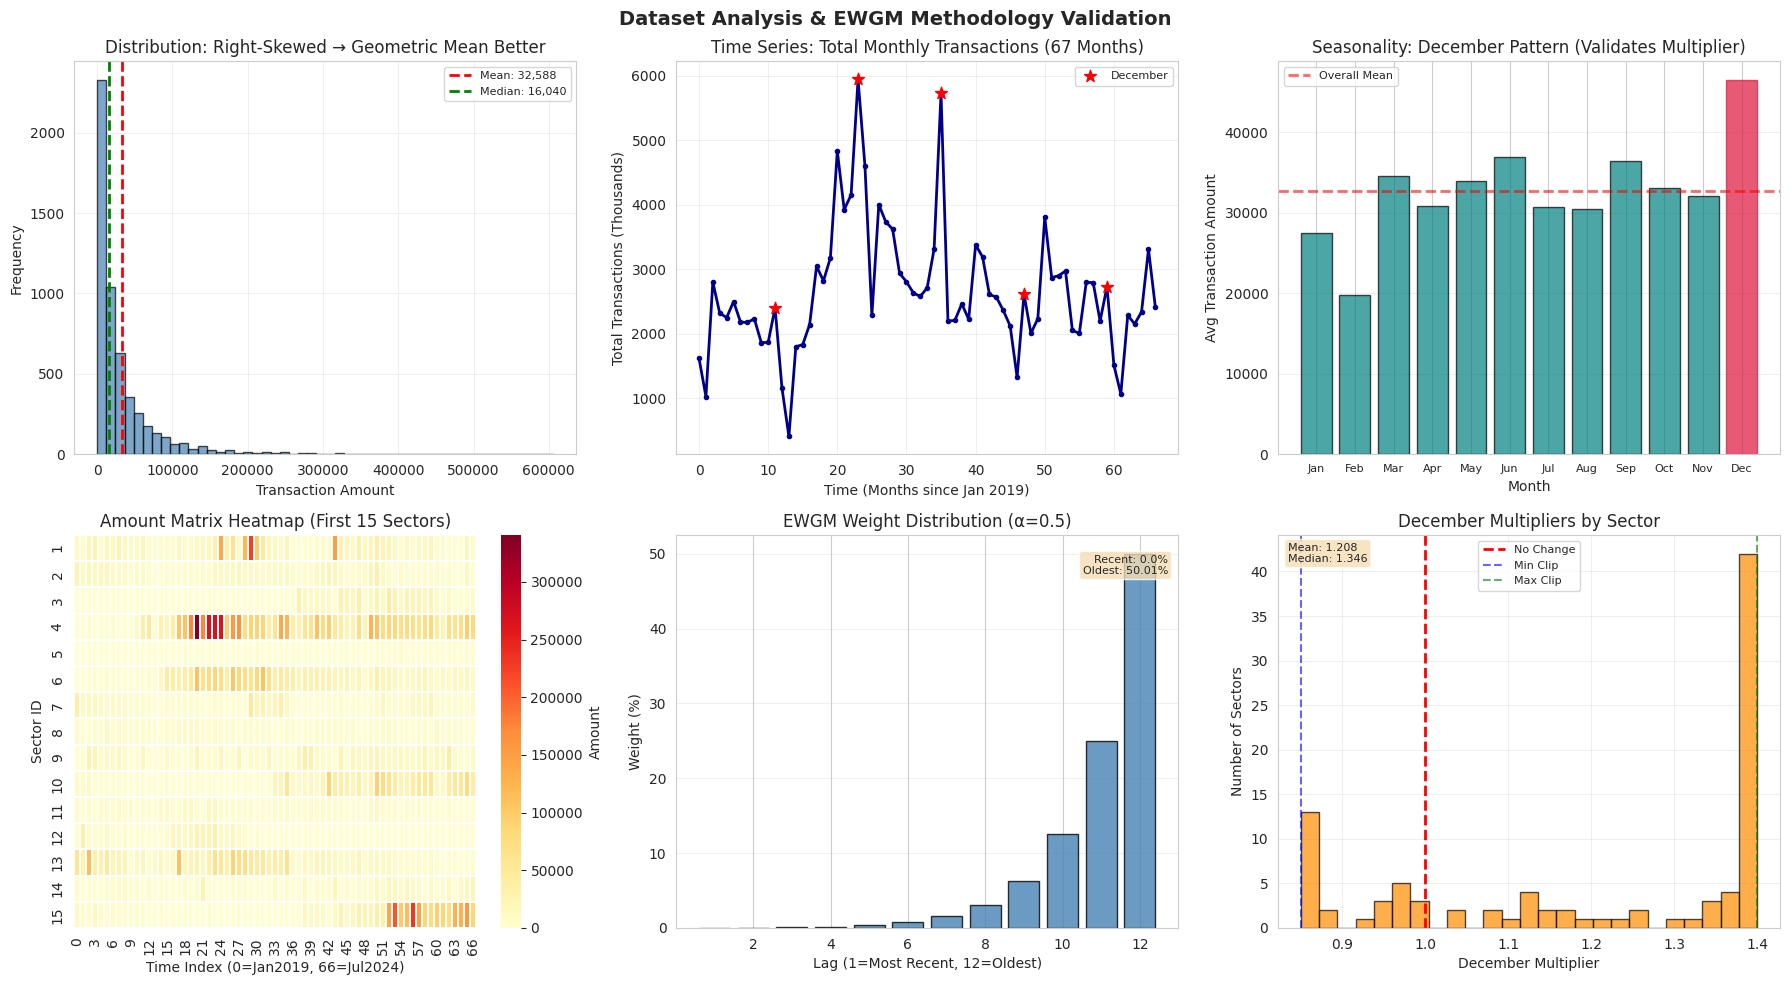

In [50]:

# DATA EXPLORATION & VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("=" * 80)
print("DATA ANALYSIS & VISUALIZATION")
print("=" * 80)



# Amount Matrix Analysis

sector_totals = a_tr.sum(axis=0).sort_values(ascending=False)
zero_pct = 100 * (a_tr == 0).sum().sum() / (a_tr.shape[0] * a_tr.shape[1])

print(f"\n Amount Matrix: {a_tr.shape[0]} months × {a_tr.shape[1]} sectors | "
      f"Sparsity: {zero_pct:.1f}% zeros")
print(f"Top 5 Active Sectors: {', '.join([f'S{s}' for s in sector_totals.head(5).index])}")


# Visualizations (6 panels)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Dataset Analysis & EWGM Methodology Validation', fontsize=14, fontweight='bold')

# Plot 1: Distribution (shows why geometric mean is better)
ax1 = axes[0, 0]
ax1.hist(amounts[amounts > 0], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(amounts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {amounts.mean():,.0f}')
ax1.axvline(amounts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {amounts.median():,.0f}')
ax1.set_xlabel('Transaction Amount')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution: Right-Skewed → Geometric Mean Better')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# Plot 2: Time Series (monthly aggregated)
ax2 = axes[0, 1]
train_ts = train_nht.copy()
train_ts = add_time_and_sector_fields(train_ts, month_codes)
monthly_agg = train_ts.groupby('time')['amount_new_house_transactions'].sum().values
ax2.plot(range(len(monthly_agg)), monthly_agg / 1000, linewidth=2, color='darkblue', marker='o', markersize=3)
dec_idx = [i for i in range(len(monthly_agg)) if i % 12 == 11]
ax2.scatter(dec_idx, [monthly_agg[i]/1000 for i in dec_idx], color='red', s=80, zorder=5, marker='*', label='December')
ax2.set_xlabel('Time (Months since Jan 2019)')
ax2.set_ylabel('Total Transactions (Thousands)')
ax2.set_title('Time Series: Total Monthly Transactions (67 Months)')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# Plot 3: Seasonality Pattern
ax3 = axes[0, 2]
seasonal = train_ts.groupby('month_num')['amount_new_house_transactions'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bars = ax3.bar(range(1, 13), seasonal.values, color='teal', edgecolor='black', alpha=0.7)
bars[11].set_color('crimson')
ax3.axhline(seasonal.mean(), color='red', linestyle='--', linewidth=2, alpha=0.6, label='Overall Mean')
ax3.set_xlabel('Month')
ax3.set_ylabel('Avg Transaction Amount')
ax3.set_title('Seasonality: December Pattern (Validates Multiplier)')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(months, fontsize=8)
ax3.legend(fontsize=8)
ax3.grid(alpha=0.3, axis='y')

# Plot 4: Matrix Heatmap (sample sectors)
ax4 = axes[1, 0]
sample_sectors = list(range(1, 16))
heatmap_data = a_tr[sample_sectors].T
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Amount'}, linewidths=0.1, ax=ax4)
ax4.set_xlabel('Time Index (0=Jan2019, 66=Jul2024)')
ax4.set_ylabel('Sector ID')
ax4.set_title('Amount Matrix Heatmap (First 15 Sectors)')

# Plot 5: EWGM Weights (α=0.5, n=12)
ax5 = axes[1, 1]
alpha, n_lags = 0.5, 12
weights = np.array([alpha**(n_lags - 1 - i) for i in range(n_lags)])
weights_norm = weights / weights.sum()
bars = ax5.bar(range(1, n_lags + 1), weights_norm * 100, color='steelblue', edgecolor='black', alpha=0.8)
bars[0].set_color('crimson')
ax5.set_xlabel('Lag (1=Most Recent, 12=Oldest)')
ax5.set_ylabel('Weight (%)')
ax5.set_title(f'EWGM Weight Distribution (α={alpha})')
ax5.grid(alpha=0.3, axis='y')
ax5.text(0.98, 0.95, f'Recent: {weights_norm[0]*100:.1f}%\nOldest: {weights_norm[-1]*100:.2f}%', 
         transform=ax5.transAxes, ha='right', va='top', fontsize=8,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 6: December Multipliers
ax6 = axes[1, 2]
mult_values = list(sector_to_mult.values())
ax6.hist(mult_values, bins=25, color='darkorange', edgecolor='black', alpha=0.7)
ax6.axvline(1.0, color='red', linestyle='--', linewidth=2, label='No Change')
ax6.axvline(0.85, color='blue', linestyle='--', alpha=0.6, label='Min Clip')
ax6.axvline(1.40, color='green', linestyle='--', alpha=0.6, label='Max Clip')
ax6.set_xlabel('December Multiplier')
ax6.set_ylabel('Number of Sectors')
ax6.set_title('December Multipliers by Sector')
ax6.legend(fontsize=8)
ax6.grid(alpha=0.3)
ax6.text(0.02, 0.98, f'Mean: {np.mean(mult_values):.3f}\nMedian: {np.median(mult_values):.3f}', 
         transform=ax6.transAxes, va='top', fontsize=8,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


